<h1 align="center">PREDICTING ANIMAL ADOPTION</h1>

<img src="https://raw.githubusercontent.com/jbonfardeci/austin-animal-shelter-model/master/aas_header.png" alt="Austin Animal Center" />

### Figure 1.0 - Global variables

In [1]:
# Change These Parameter Constants

# Saving output
SAVE_FIGS = True
OUTPUT_TO_CSV = True
OUTPUT_DIR = 'output/'

# relative file path; can place in same working directory as notebook
FILE_PATH = 'animal_shelter_train.csv'

# name of target column
TARGET_NAME = 'Adopted'

# Name of Key/ID column
KEY_NAME='AnimalID'

# what value represents the positive value in a binary response: e.g. 1, 'Y', 'T', ...
TARGET_VALUE = 1 

# LDA Solver to use. 
#    Options: 
#        'lsqr' (Least squares solution) - can use with shrikage
#        'svd' (Singular value decomposition) - use with large num features
#        'eigen' (Eigenvalue decomposition) - can use with shrikage
# http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
LDA_SOLVER = 'lsqr'

# change to None to run LDA without shrinkage
# Options: None, 'auto', float between 0 and 1
# see http://scikit-learn.org/stable/auto_examples/classification/plot_lda.html#sphx-glr-auto-examples-classification-plot-lda-py
LDA_SHRINKAGE = 'auto'

# Number of cross-validation groups to run
NUM_CV = 5

# Seed for random sampling
RAND_SEED = 12345

# Define global vars
X = None # Matrix of predictor variables
y = None # Dependent variable list
keys = None # Key/ID values
columns = None # Names of variables
df_raw = None # Pandas DataFrame for raw imported data.
df = None # Pandas DataFrame to store our model data.
df_coef = None # DataFrame to store predictor coefficients and p-values

### Figure 1.1 - Import External Libraries

In [2]:
#Import Dependent Libraries
# DON'T change below this line unless you know what your're doing.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import math
import pandas as pd
import numpy as np
from scipy import interp
from itertools import cycle
from copy import copy

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE, SelectFromModel, SelectFpr
from IPython.display import display
import re
import statsmodels.api as sm
import os
import seaborn as sns
from sklearn.naive_bayes import GaussianNB

import warnings; warnings.simplefilter('ignore')

## Import our custom stat utility class library.

In [3]:
from StatUtilities import Utilities as u

# Sample

### Figure 2.0 - Import Raw Data

In [4]:
# Import data and display a summary table.
def import_data(file_path):
    """
    Import a CSV file to a Pandas dataframe.
    @param file_path <string>
    @return Pandas Dataframe
    """
    try:
        if not os.path.exists(file_path):
            print('Invalid file path!')
            return None

        df = pd.read_csv(file_path) # returns new Pandas DataFrame 
        return df
    except IOError:
        print('Error reading file ' + file_path)
        return None

if __name__ == '__main__':
    df_raw = import_data(FILE_PATH)
    df_raw = df_raw.drop('DateTime', 1).drop('OutcomeSubtype', 1).drop('AnimalID', 1).drop('Name', 1)
    display(df_raw.describe())

,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,26729,26728,26711,26729,26729
unique,5,2,5,44,1380,366
top,Adoption,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,10769,15595,9779,3969,8810,2824


# Explore

### Figure 3.0 - Univariate Analysis

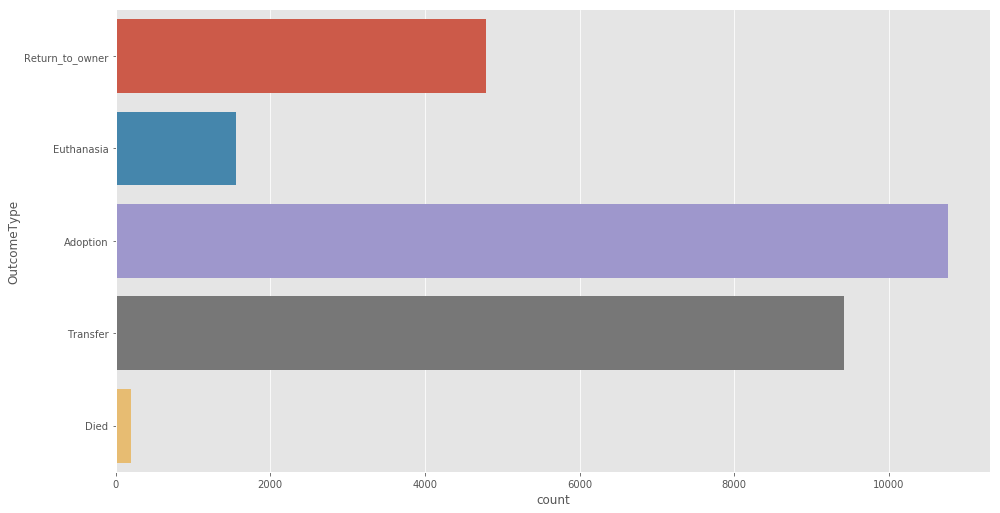

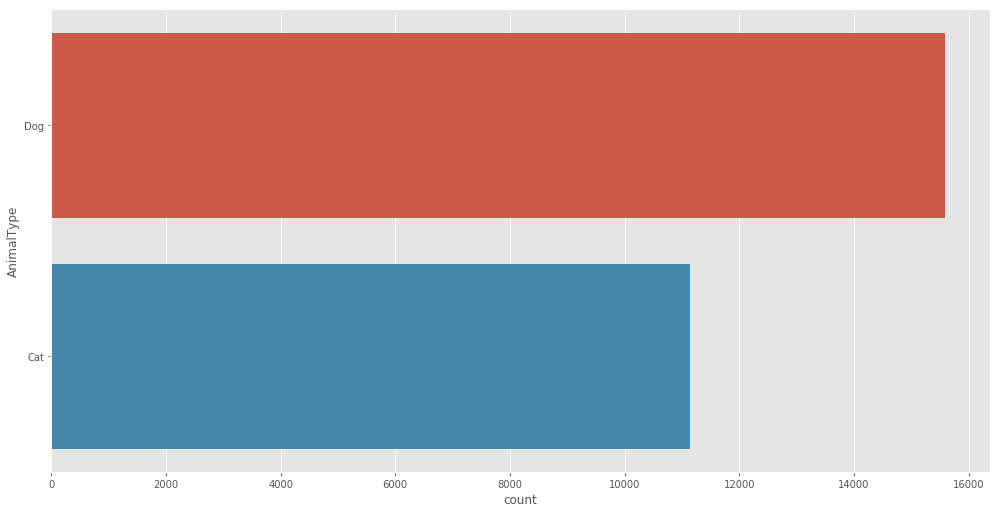

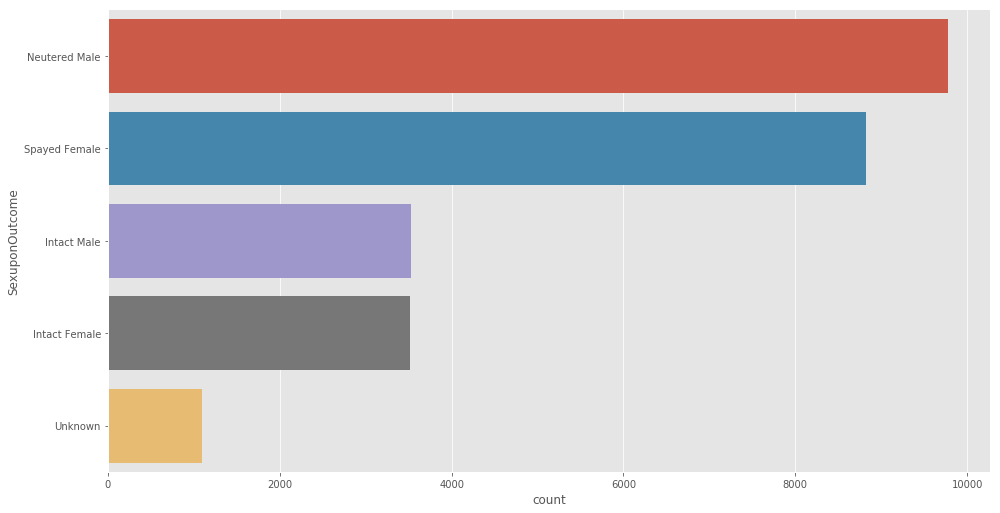

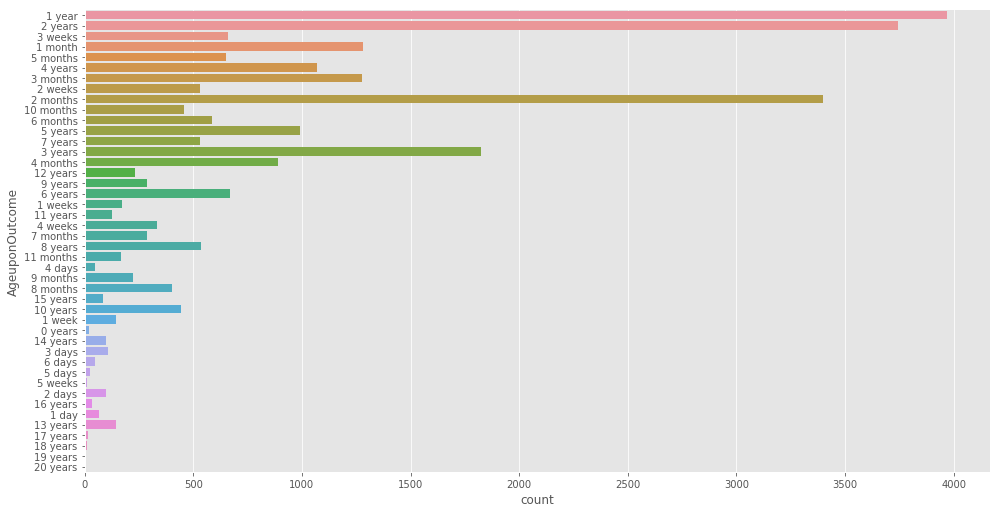

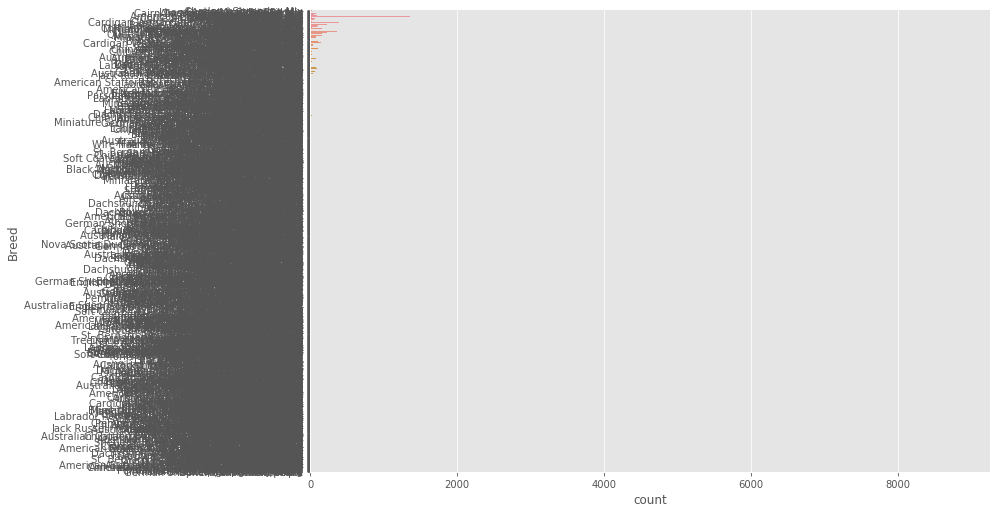

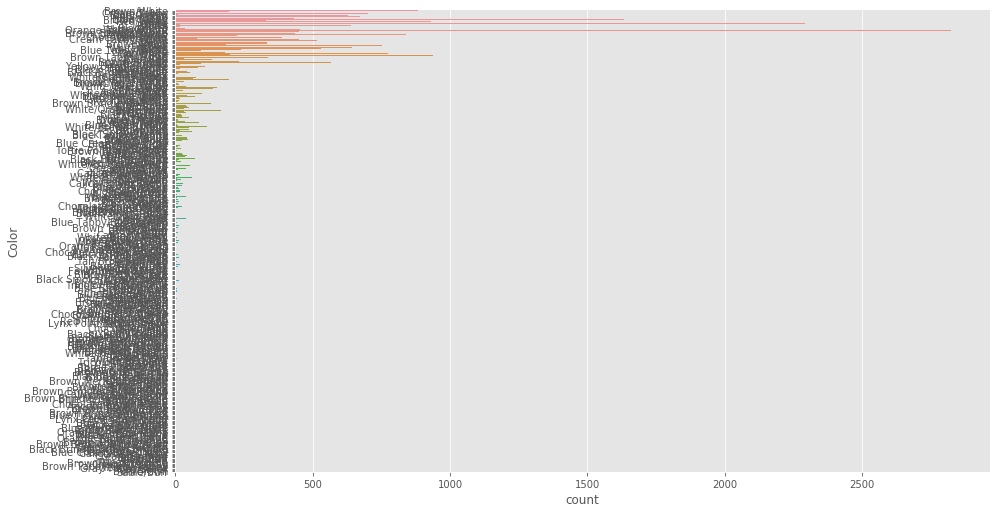

In [5]:
# Create histograms for each variable.
def get_class_plots(df):
    tmp = pd.DataFrame()
    if type(df) != type(tmp):
        print("Parameter 'df' must be of type DataFrame.")
        return
    """
    Display histograms for all the class variables.
    """
    for col in df.columns:
        ax = sns.factorplot(y=col, kind='count', data=df, size=7, aspect=2)
        plt.show()

if __name__ == '__main__':
    get_class_plots(df_raw)

# Modify

### Figure 4.0 - Transform the Dataset

In [6]:
def transform(dataframe):
    tmp = pd.DataFrame()
    if type(dataframe) != type(tmp):
        print("Parameter 'df' must be of type DataFrame.")
        return
    
    """
    Transform the raw data into usable indicator columns.
    Create new predictors from more concise grouping of categories.
    @param dataframe
    @param target_name
    @returns [y<list>, matrix<list<list>>, dataframe, columns<list>]
    """
    # drop NA
    dataframe = dataframe.dropna()
    #randomize the data
    dataframe = dataframe.sample(frac=1.0, random_state=RAND_SEED)
    #dataframe.iloc[np.random.permutation(len(dataframe))]
    
    matrix = []
    columns = ['Adopted', 'Cat', 'AgeRange_0', 'AgeRange_1_4', 'AgeRange_5_9', 'AgeRange_10_14', 'AgeRange_15_20',
              'SexuponOutcome', 'ColorCat', 'MixBreed']
    
    for index, row in dataframe.iterrows():
        
        # Adopted
        outcome = 1 if row['OutcomeType'] == 'Adoption' else 0
        
        # Cat or Dog
        cat = 1 if row['AnimalType'] == 'Cat' else 0
        
        # Group ages into age categories.
        age_cat = str(row['AgeuponOutcome'])
        age = int(re.sub('\\D+', '', age_cat))
        ageRange_0 = 0
        ageRange_1_4 = 0
        ageRange_5_9 = 0
        ageRange_10_14 = 0 
        ageRange_15_20 = 0
        
        if age_cat.find('months') > -1:
            ageRange_0 = 1
        else:
            ageRange_1_4 = 1 if age >= 1 and age < 5 else 0
            ageRange_5_9 = 1 if age >= 5 and age < 10 else 0
            ageRange_10_14 = 1 if age >= 10 and age < 15 else 0
            ageRange_15_20 = 1 if age >= 15 else 0
        
        sex = row['SexuponOutcome']
        
        # Combine colors that are similar
        colorCat = None
        color = row['Color']
        
        if color == 'White/Black' or color == 'Black/White':
            colorCat = 'Black/White'
        elif color == 'Tan/Black' or color == 'Black/Tan':
            colorCat = 'Black/Tan'
        elif color == 'Brown/Black' or color == 'Black/Brown':
            colorCat = 'Black/Brown'
        elif color == 'White/Blue' or color == 'Blue/White':
            colorCat = 'Blue/White'
        elif color == 'Brown' or color == 'Chocolate' or color == 'Brown Tabby':
            colorCat = 'Brown'
        elif color == 'White/Brown' or color == 'Brown/White':
            colorCat = 'Brown/White'
        elif color == 'White/Tan' or color == 'Tan':
            colorCat = 'Tan'
        elif color == 'Yellow/White' or color.rfind('Yellow') == 0:
            colorCat = 'Yellow'
        elif color.find('White') == 0:
            colorCat = 'White'
        elif color.find('Blue') == 0:
            colorCat = 'Blue'
        elif color.find('Black') == 0:
            colorCat = 'Black'
        elif color.find('Tricolor') == 0:
            colorCat = 'Tricolor'
        elif color.find('Tortie') == 0:
            colorCat = 'Tortie'
        elif color == 'Calico':
            colorCat = 'Calico'
        elif color.find('Red') == 0:
            colroCat = 'Red'
        else:
            colorCat = color
        
        #breed = row['Breed']
        
        # Mix
        mixedBreed = 1 if row['Breed'].lower().find('mix') > -1 else 0

        a = [outcome, cat, ageRange_0, ageRange_1_4, ageRange_5_9, ageRange_10_14, ageRange_15_20, 
             sex, colorCat, mixedBreed]
        
        matrix.append(a)
    # /end for...
        
    df = pd.DataFrame(data=matrix, columns=columns) # Create dataframe
    df = pd.get_dummies(df)
    
    # Clean col names removing special characters
    df.columns = map(lambda c: re.sub('[^a-zA-Z0-9_]', '_', c), df.columns)
    
    # Get list of actual Y outcomes
    y = pd.Series( map(lambda x: 1 if x == 1 else 0, df['Adopted']) ).as_matrix()
    df = df.drop('Adopted', 1) # can't include Y as predictor, drop
    X = df.as_matrix() # Get predictors only
    return [y, X, df, df.columns]
    
if __name__ == '__main__':
    y, X, df, columns = transform(dataframe=df_raw)
    display(df.describe())

,Cat,AgeRange_0,AgeRange_1_4,AgeRange_5_9,AgeRange_10_14,AgeRange_15_20,MixBreed,SexuponOutcome_Intact_Female,SexuponOutcome_Intact_Male,SexuponOutcome_Neutered_Male,...,ColorCat_Torbie,ColorCat_Torbie_Blue_Cream,ColorCat_Torbie_Brown,ColorCat_Torbie_Calico,ColorCat_Torbie_White,ColorCat_Tortie,ColorCat_Tricolor,ColorCat_White,ColorCat_Yellow,ColorCat_Yellow_Yellow
count,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,...,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000
mean,0.416211,0.312205,0.525983,0.116099,0.039161,0.005728,0.834145,0.131187,0.131748,0.366118,...,0.012505,0.000037,0.000037,0.000037,0.002246,0.022950,0.029951,0.060314,0.009734,0.000037
std,0.492939,0.463402,0.499334,0.320349,0.193982,0.075469,0.371958,0.337611,0.338223,0.481751,...,0.111125,0.006119,0.006119,0.006119,0.047343,0.149748,0.170456,0.238073,0.098182,0.006119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Figure 4.1 - Get Estmimates Coefficients and P-values

In [7]:
def get_var_estimates(target_name, y, X, columns):
    """
    Show OLS parameter estimates for the model.
    Ref: http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.RegressionResults.html
    http://statsmodels.sourceforge.net/devel/examples/generated/example_ols.html
    @param target_name <string>
    @param y <list>
    @param X <Pandas Dataframe>
    @param columns <list>
    @returns Statsmodel summary
    """
    model = sm.OLS(y, X)
    results = model.fit()
    return results.summary(yname=target_name, xname=columns, title='PValues', alpha=0.05)
    
if __name__ == '__main__':
    summary = get_var_estimates(target_name=TARGET_NAME, y=y, X=X, columns=[c for c in columns])
    #display(summary)
    #print(dir(summary))
    display(summary)
    # output estimates to CSV
    outfile = open(OUTPUT_DIR+'initial_estimates.csv', 'w')
    outfile.write(summary.tables[1].as_csv())
    outfile.close()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   PValues                                    
==============================================================================
Dep. Variable:                Adopted   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     62.70
Date:                Tue, 11 Dec 2018   Prob (F-statistic):               0.00
Time:                        09:32:41   Log-Likelihood:                -13574.
No. Observations:               26710   AIC:                         2.756e+04
Df Residuals:                   26503   BIC:                         2.926e+04
Df Model:                         206                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Cat                                      0.0450      0.008      5.546      0.000       0.029       0.061
AgeRange_0                               0.2274      0.089      2.565      0.010       0.054       0.401
AgeRange_1_4                            -0.0105      0.089     -0.118      0.906      -0.184       0.163
AgeRange_5_9                            -0.1374      0.089     -1.547      0.122      -0.312       0.037
AgeRange_10_14                          -0.1901      0.089     -2.126      0.034      -0.365      -0.015
AgeRange_15_20                          -0.2652      0.094     -2.808      0.005      -0.450      -0.080
MixBreed                                -0.0156      0.007     -2.210      0.027      -0.030      -0.002
SexuponOutcome_Intact_Female            -0.0040      0.090     -0.044      0.965      -0.180       0.172
SexuponOutcome_Intact_Male              -0.0133      0.090     -0.148      0.882      -0.189       0.163
SexuponOutcome_Neutered_Male             0.4781      0.090      5.329      0.000       0.302       0.654
SexuponOutcome_Spayed_Female             0.5280      0.090      5.885      0.000       0.352       0.704
SexuponOutcome_Unknown                  -0.0496      0.090     -0.554      0.580      -0.225       0.126
ColorCat_Agouti                         -0.7848      0.404     -1.942      0.052      -1.577       0.007
ColorCat_Agouti_Brown_Tabby              0.2652      0.404      0.656      0.512      -0.527       1.057
ColorCat_Apricot                        -0.0182      0.089     -0.204      0.838      -0.193       0.157
ColorCat_Apricot_Brown                  -0.4135      0.286     -1.446      0.148      -0.974       0.147
ColorCat_Apricot_White                  -0.1572      0.234     -0.673      0.501      -0.615       0.301
ColorCat_Black                           0.0023      0.016      0.142      0.887      -0.030       0.034
ColorCat_Black_Brown                     0.0445      0.020      2.225      0.026       0.005       0.084
ColorCat_Black_Tan                       0.0192      0.019      0.986      0.324      -0.019       0.057
ColorCat_Black_White                     0.0069      0.016      0.442      0.659      -0.024       0.037
ColorCat_Blue                            0.0409      0.018      2.235      0.025       0.005       0.077
ColorCat_Blue_White                      0.0097      0.020      0.487      0.626      -0.029       0.049
ColorCat_Brown                           0.0088      0.017      0.523      0.601      -0.024       0.042
ColorCat_Brown_Brindle                   0.0226      0.030      0.758      0.448      -0.036       0.081
ColorCat_Brown_Brindle_Black            -0.0091      0.153     -0.059      0.953      -0.309       0.291
ColorCat_Brown_Brindle_Blue           

### Figure 4.1 - Variable Selection

Selected significant variables are:
 Cat, AgeRange_0, AgeRange_1_4, AgeRange_10_14, AgeRange_15_20, MixBreed, SexuponOutcome_Intact_Male, SexuponOutcome_Neutered_Male, SexuponOutcome_Spayed_Female, SexuponOutcome_Unknown, ColorCat_Black, ColorCat_Black_Brown, ColorCat_Black_Tan, ColorCat_Black_White, ColorCat_Blue, ColorCat_Brown, ColorCat_Brown_Brindle_White, ColorCat_Cream, ColorCat_Cream_Tabby, ColorCat_Fawn_White, ColorCat_Gold, ColorCat_Gray_White, ColorCat_Lynx_Point, ColorCat_Orange_Tabby, ColorCat_Sable, ColorCat_Sable_White, ColorCat_Tortie, ColorCat_Tricolor, ColorCat_White, ColorCat_Yellow

Dropped insignificant vars:  AgeRange_5_9, SexuponOutcome_Intact_Female, ColorCat_Agouti, ColorCat_Agouti_Brown_Tabby, ColorCat_Apricot, ColorCat_Apricot_Brown, ColorCat_Apricot_White, ColorCat_Blue_White, ColorCat_Brown_Brindle, ColorCat_Brown_Brindle_Black, ColorCat_Brown_Brindle_Blue, ColorCat_Brown_Brindle_Blue_Cream, ColorCat_Brown_Brindle_Blue_Tick, ColorCat_Brown_Brindle_Brown_Brin

,Cat,AgeRange_0,AgeRange_1_4,AgeRange_10_14,AgeRange_15_20,MixBreed,SexuponOutcome_Intact_Male,SexuponOutcome_Neutered_Male,SexuponOutcome_Spayed_Female,SexuponOutcome_Unknown,...,ColorCat_Gold,ColorCat_Gray_White,ColorCat_Lynx_Point,ColorCat_Orange_Tabby,ColorCat_Sable,ColorCat_Sable_White,ColorCat_Tortie,ColorCat_Tricolor,ColorCat_White,ColorCat_Yellow
count,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,...,26710.000000,26710.000000,26710.00000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000
mean,0.416211,0.312205,0.525983,0.039161,0.005728,0.834145,0.131748,0.366118,0.330176,0.040771,...,0.001947,0.003594,0.00629,0.031486,0.007413,0.003220,0.022950,0.029951,0.060314,0.009734
std,0.492939,0.463402,0.499334,0.193982,0.075469,0.371958,0.338223,0.481751,0.470285,0.197764,...,0.044081,0.059845,0.07906,0.174631,0.085780,0.056653,0.149748,0.170456,0.238073,0.098182
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


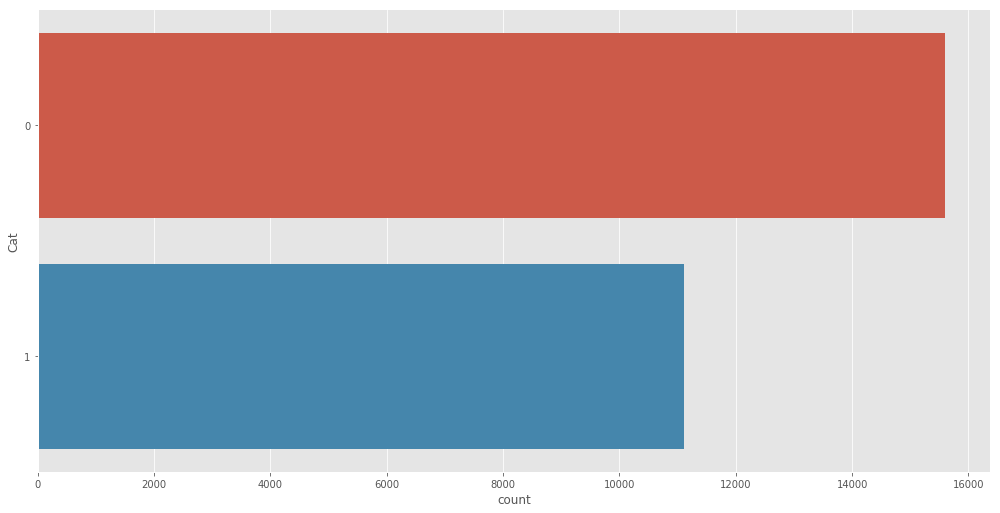

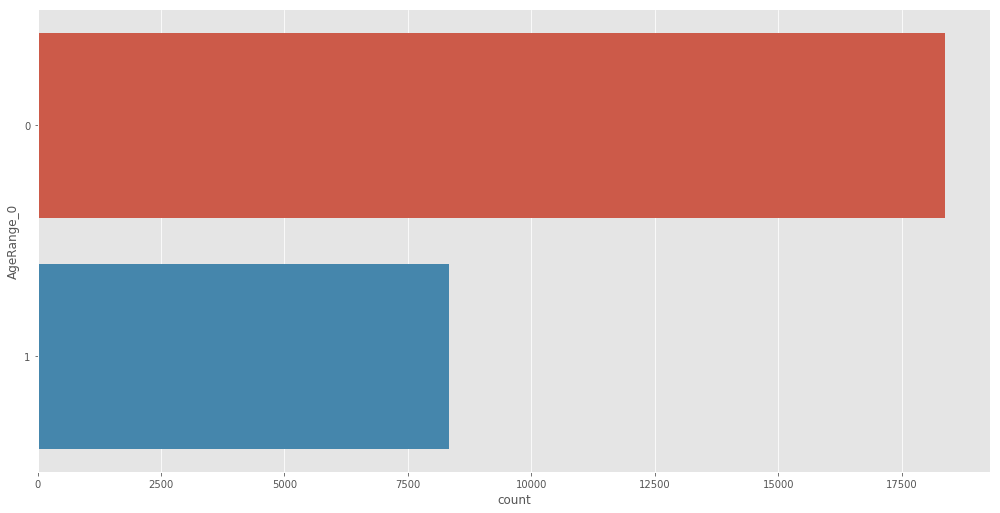

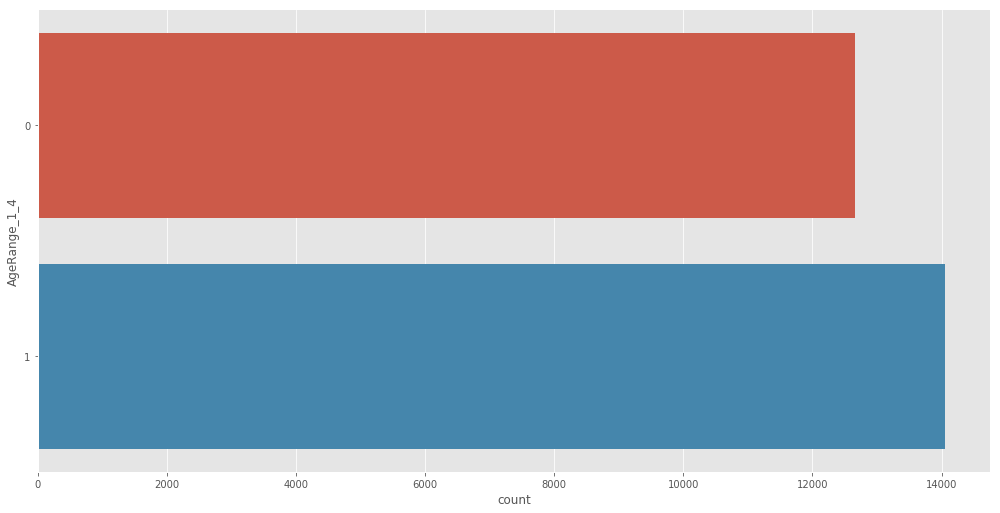

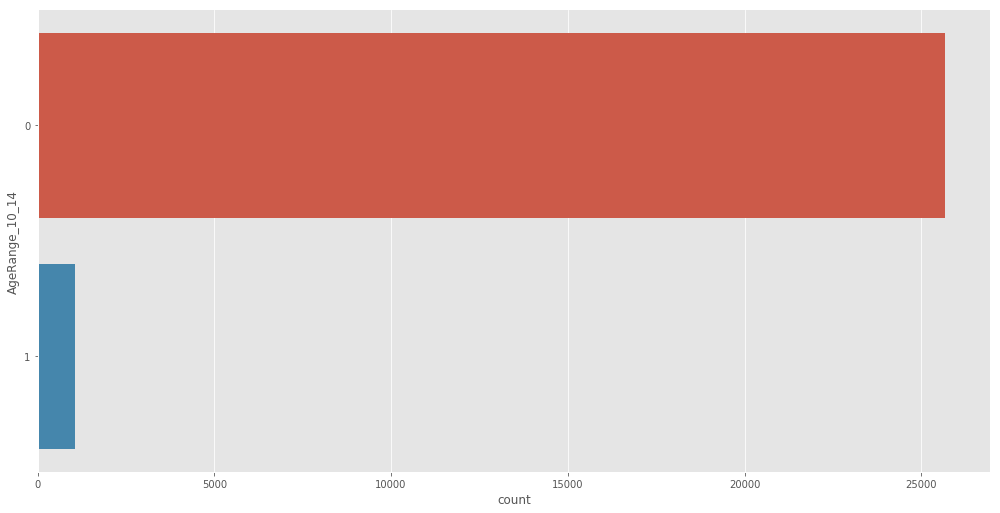

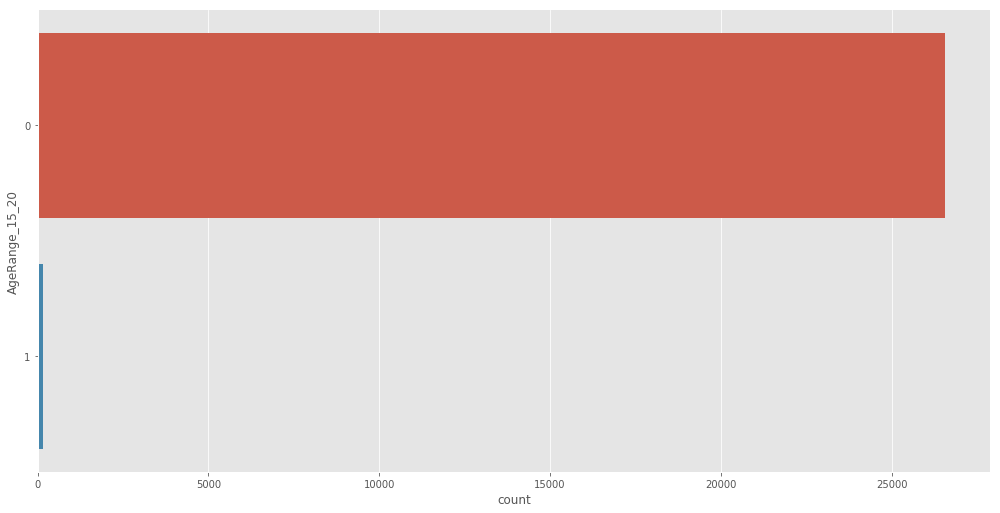

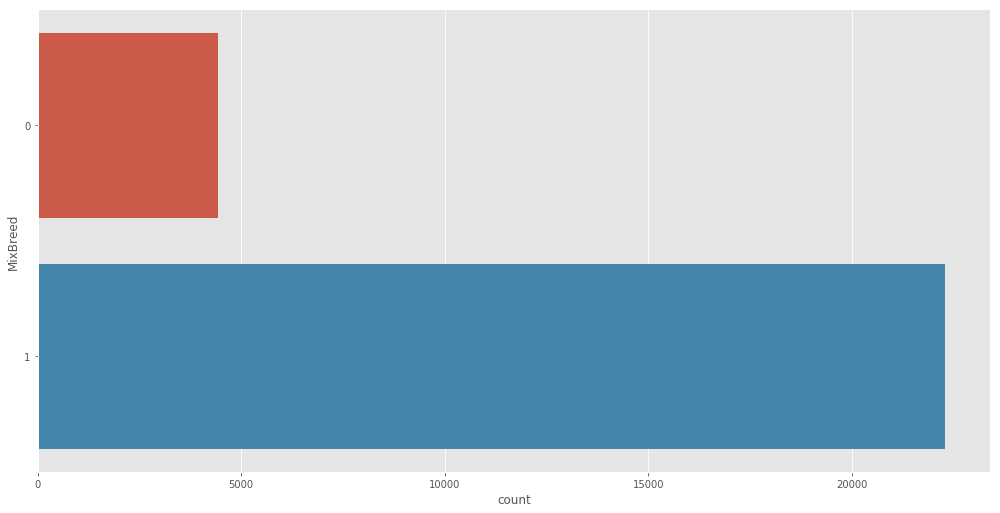

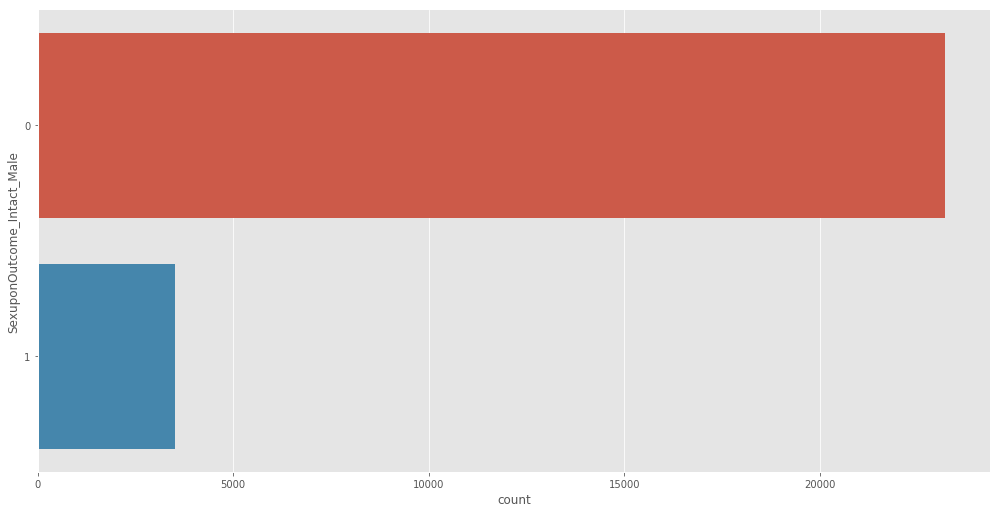

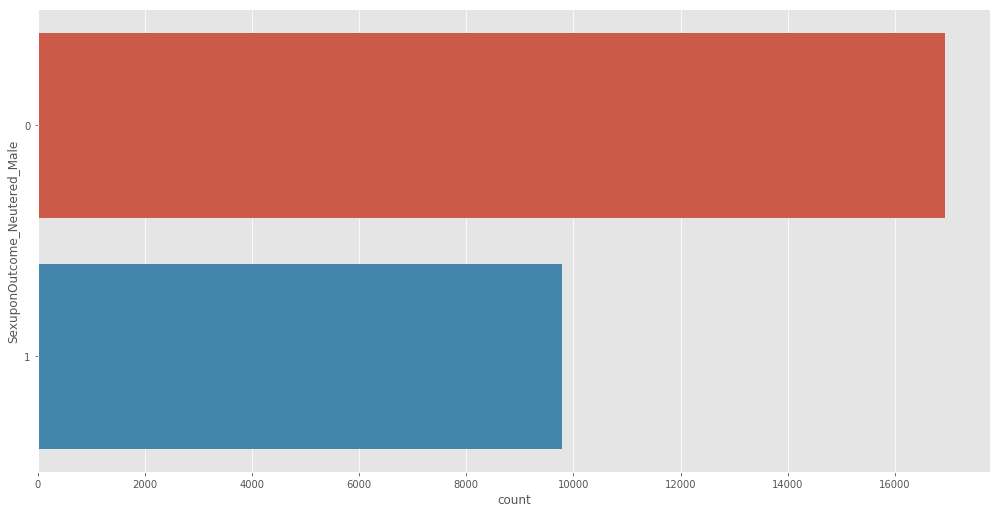

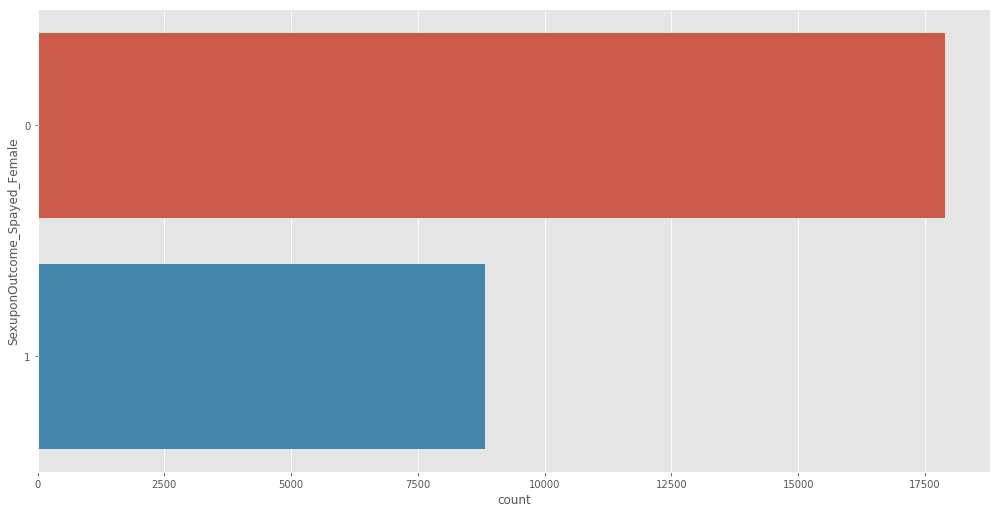

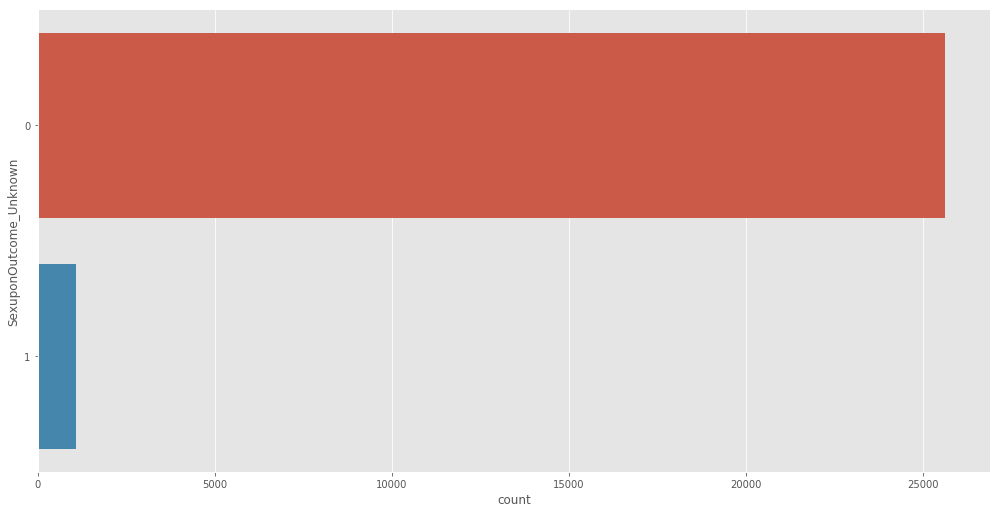

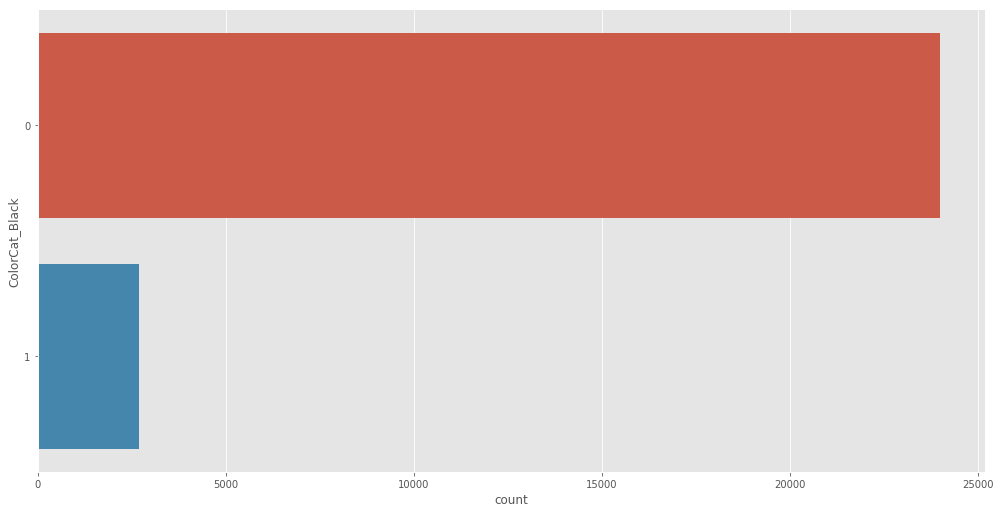

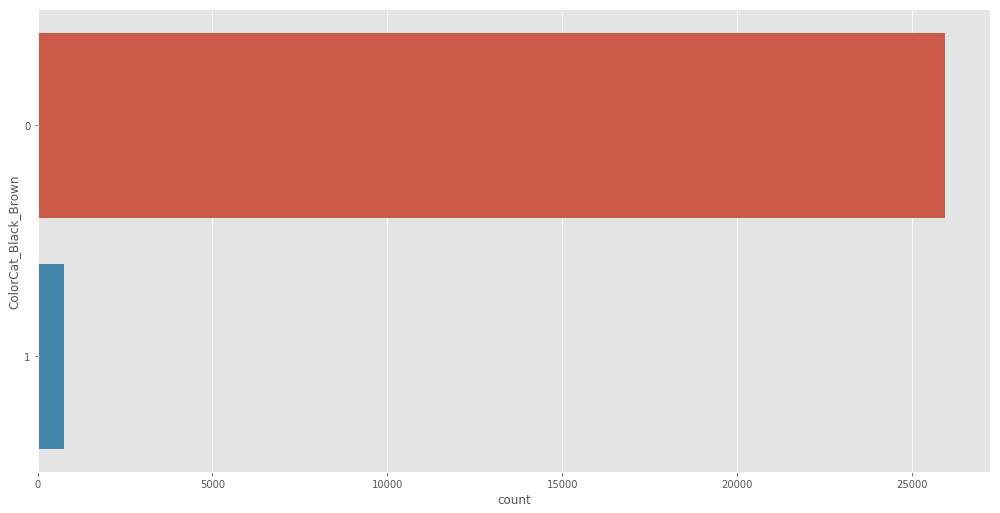

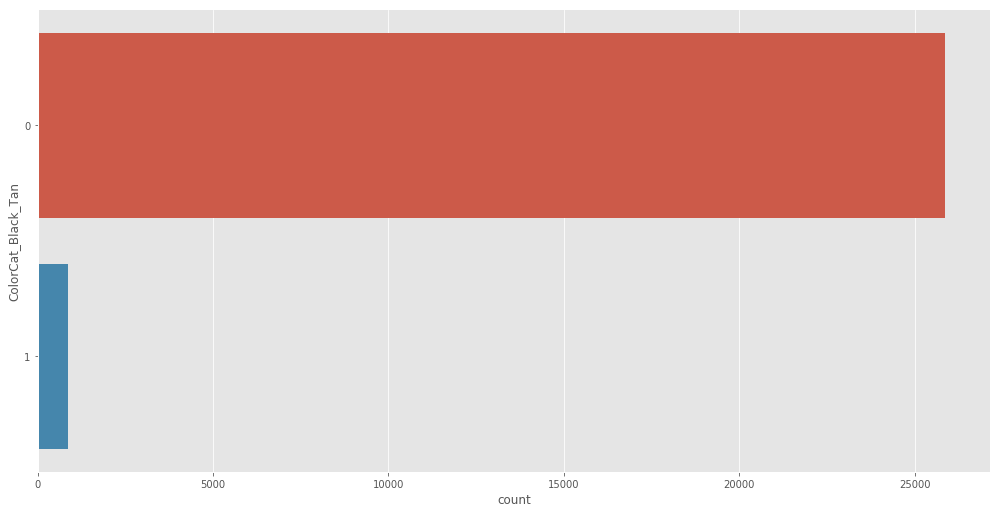

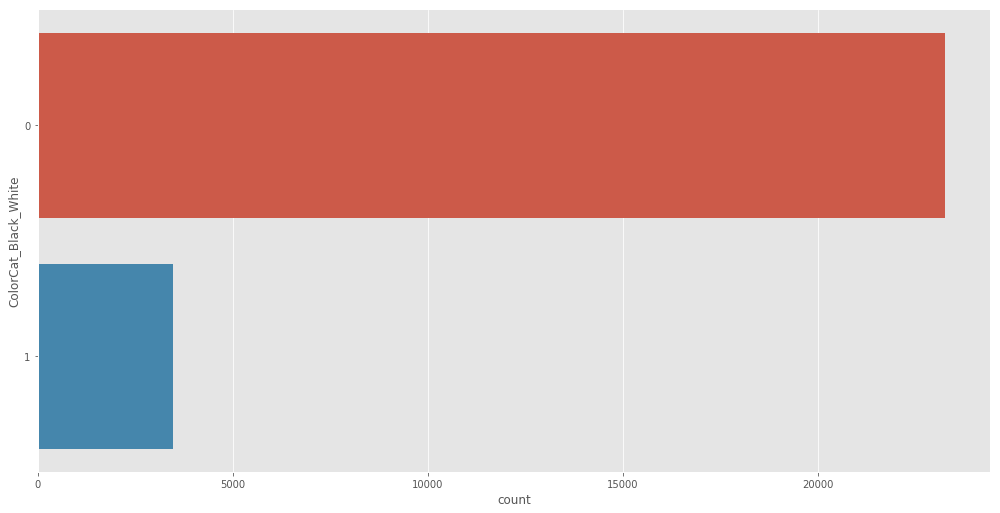

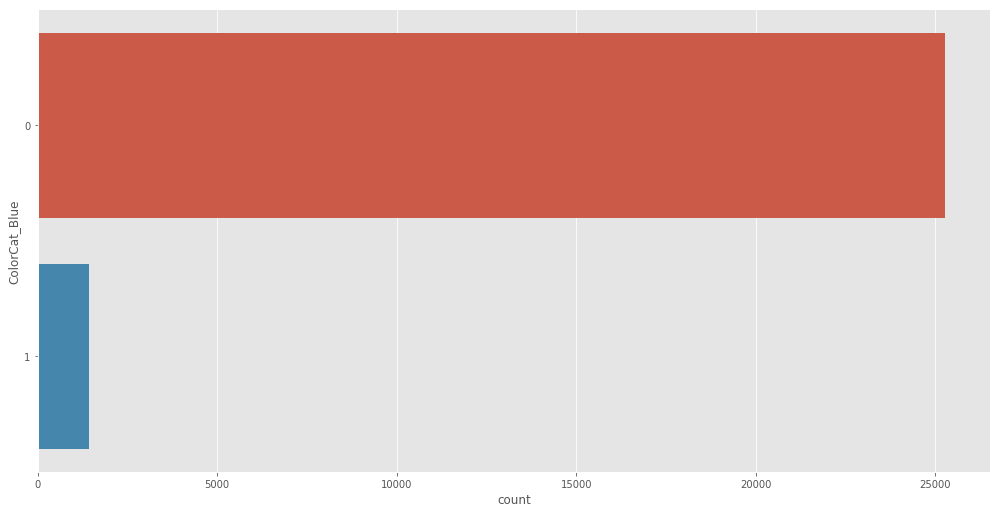

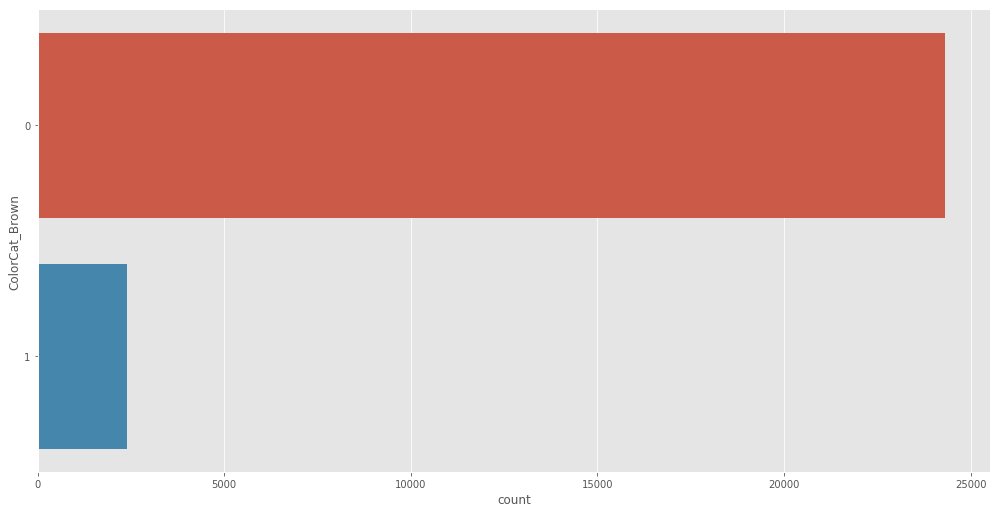

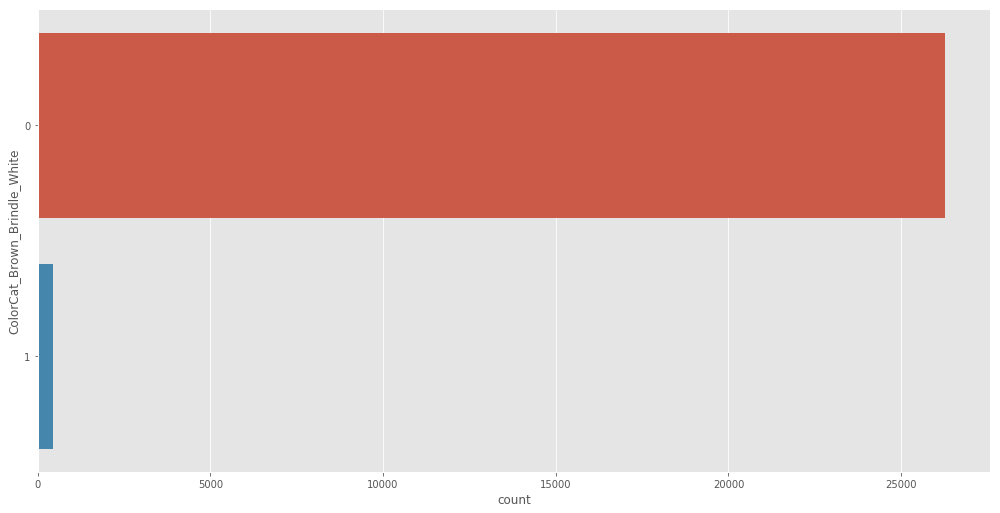

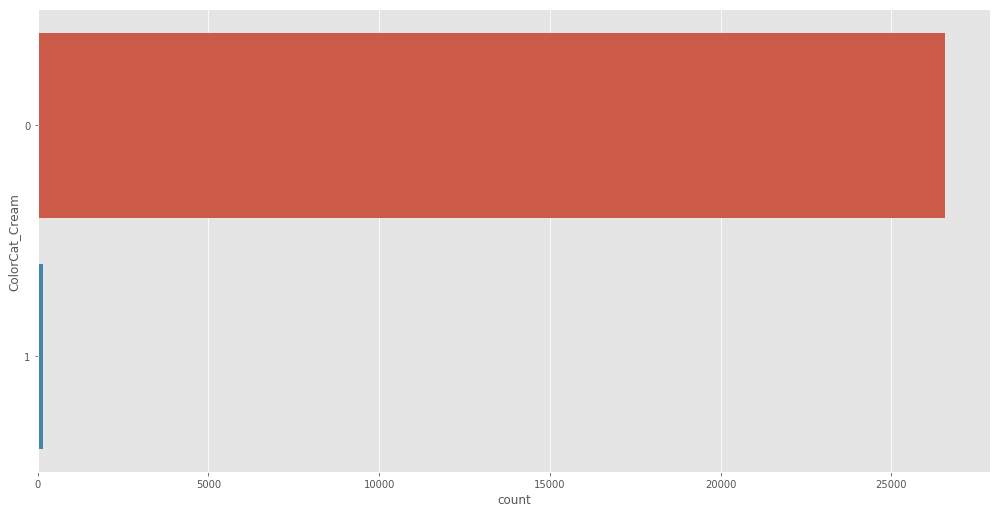

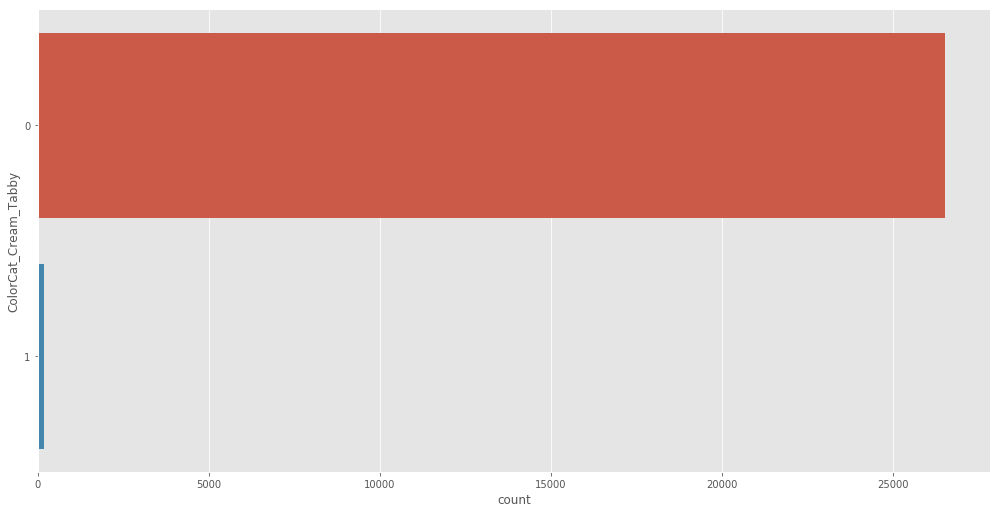

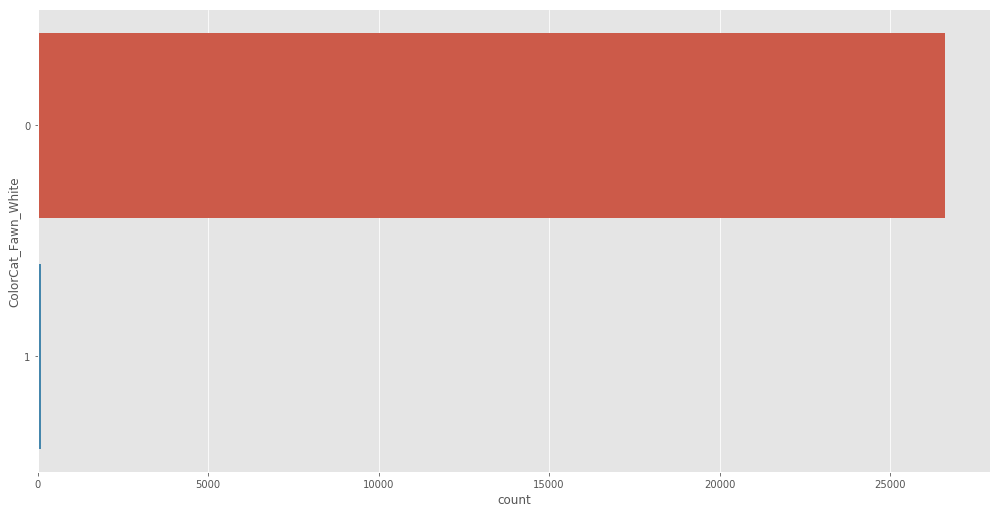

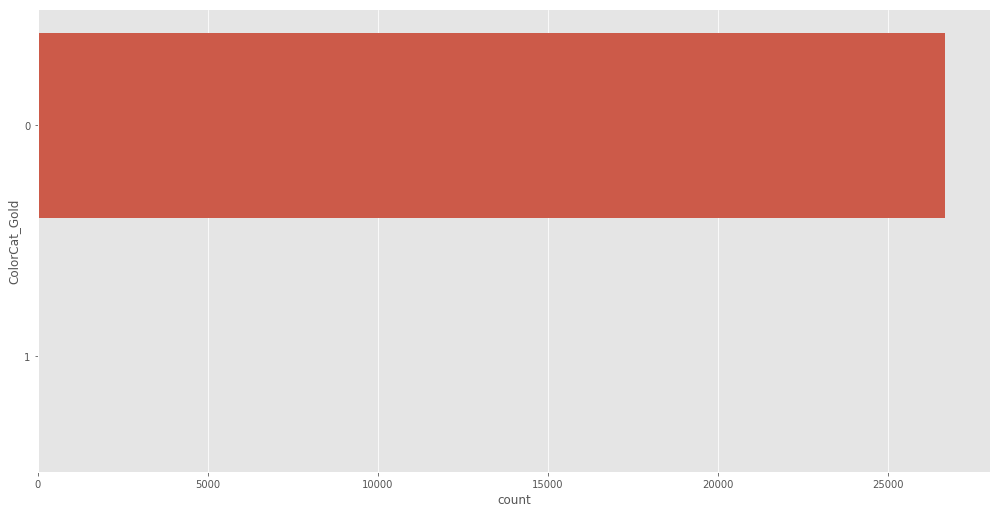

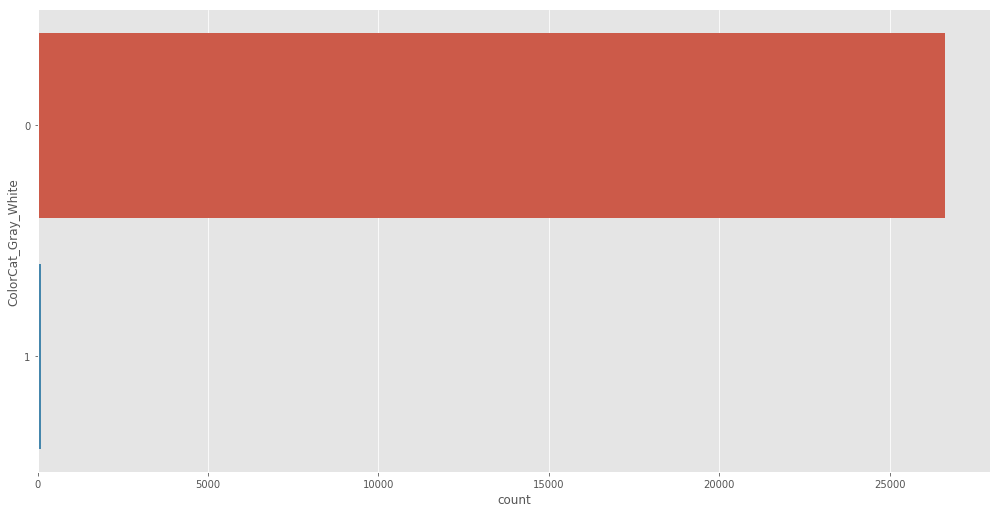

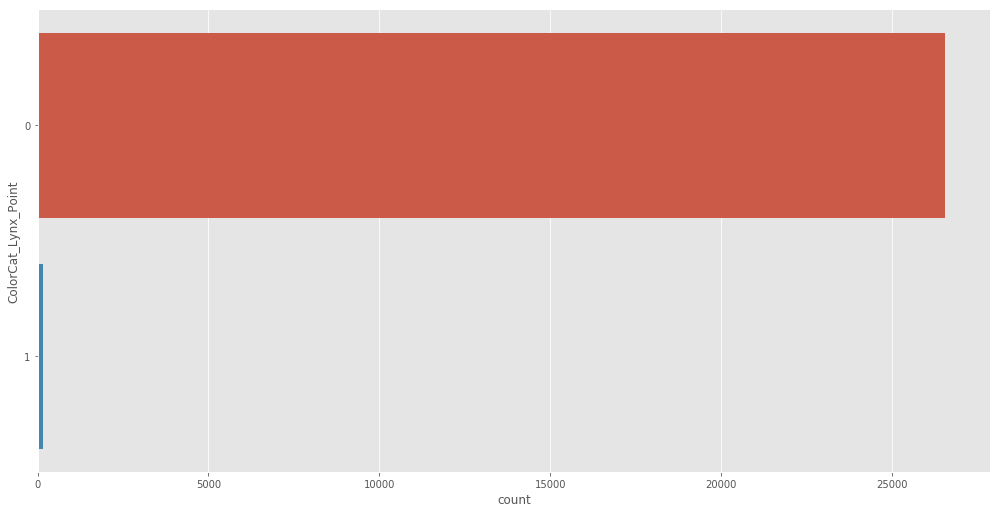

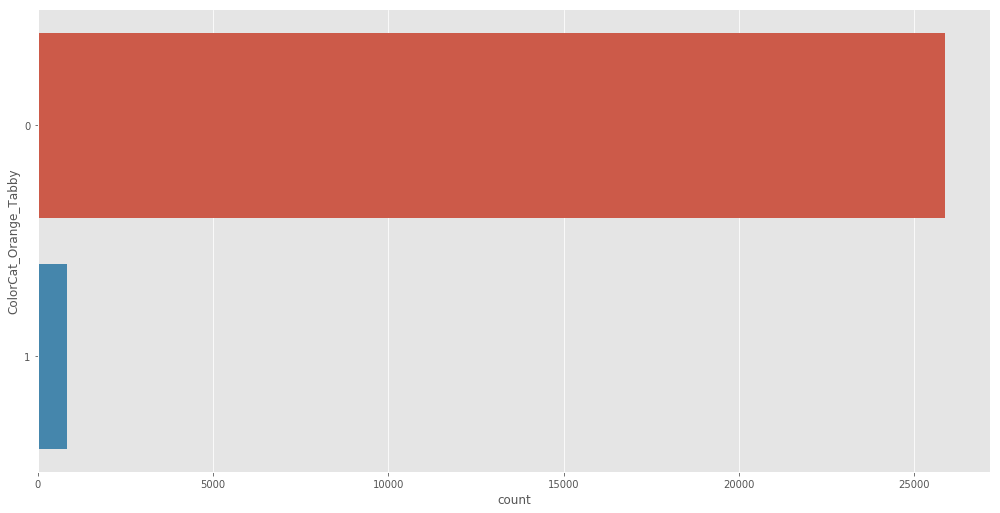

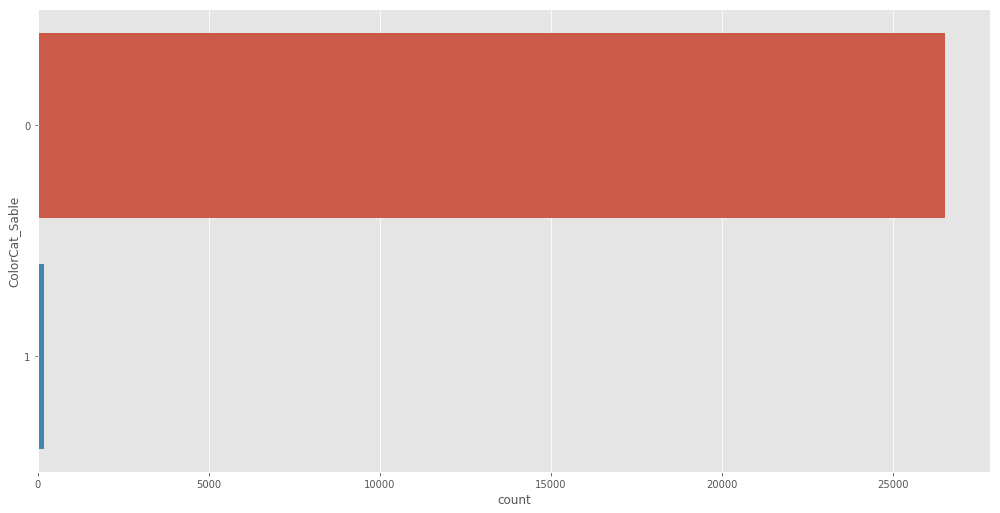

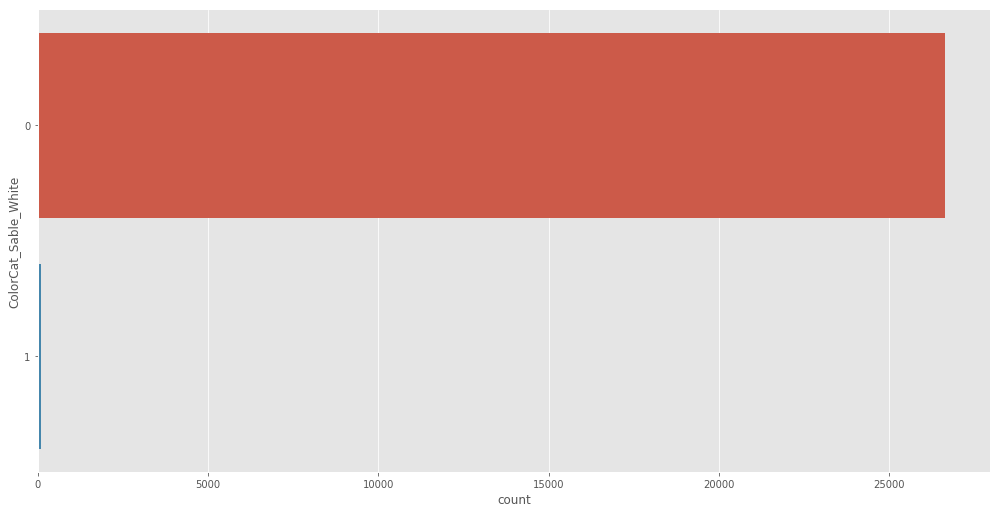

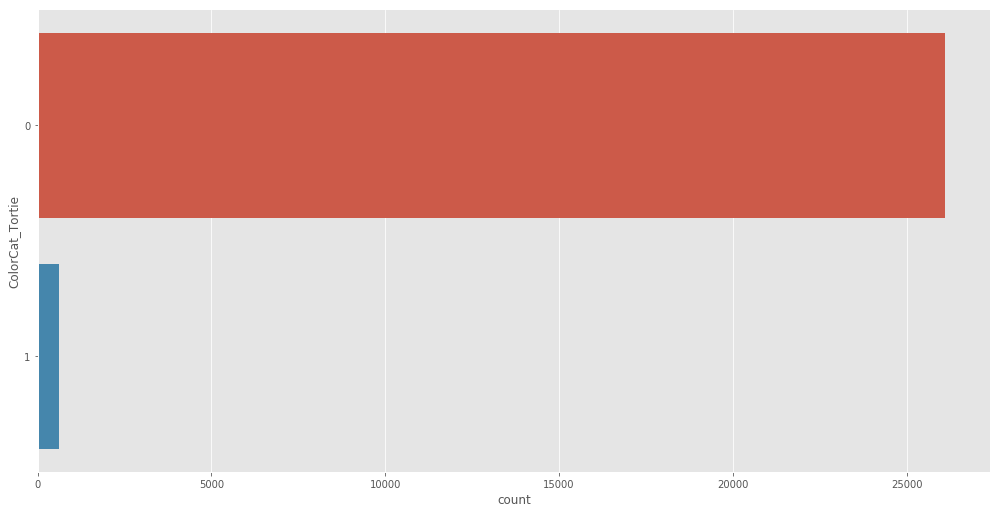

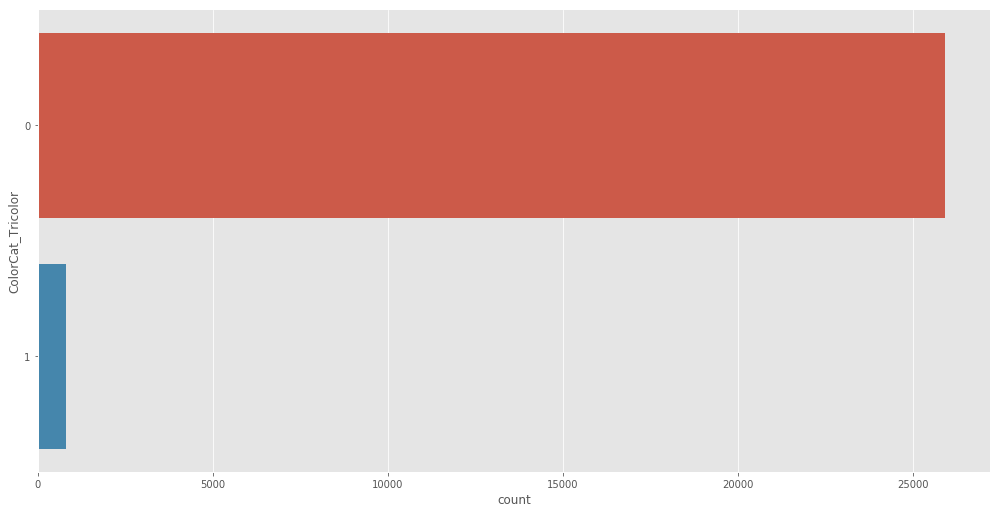

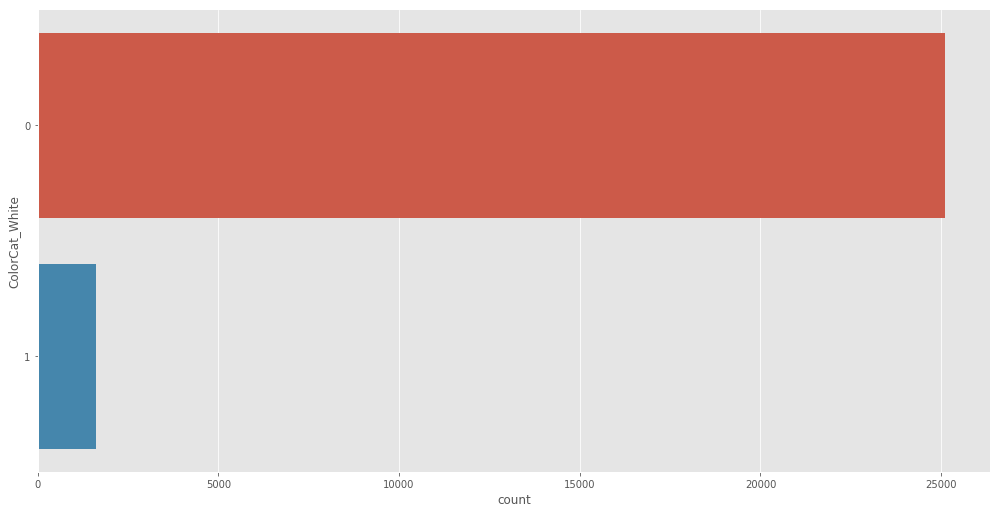

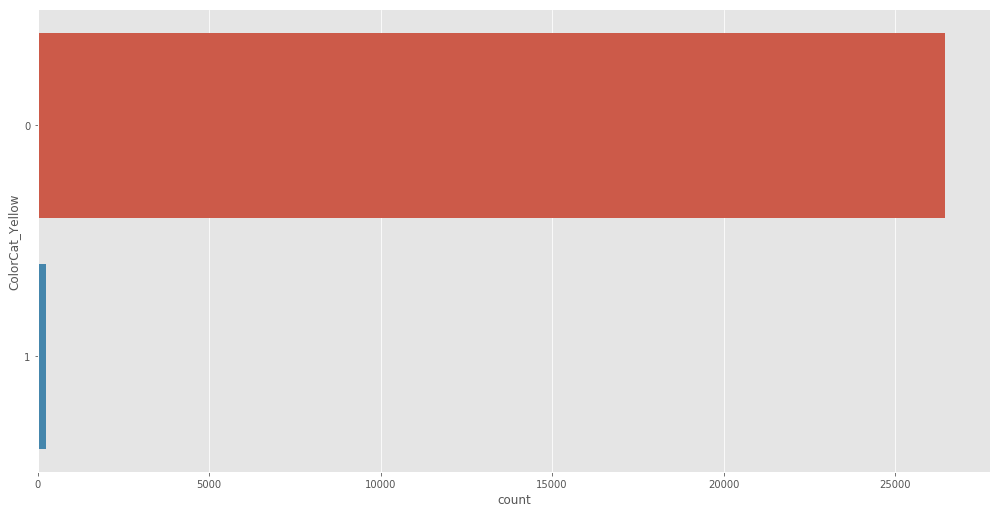

In [8]:
# Lasso feature selection
if __name__ == '__main__':
    significant_features = u.get_lasso_selection(X=X, y=y, columns=columns)
    print('Selected significant variables are:\r\n', ', '.join(significant_features))

    df = u.remove_insignificant_vars(significant_features, df.copy())
    display(df.describe())
    X = df.as_matrix() 
    columns = df.columns.tolist()
    get_class_plots(df)

### Figure 4.2 - Re-run Estimates After Variable Selection (Adj. R-Square improves)

In [9]:
if __name__ == '__main__':
    summary = get_var_estimates(target_name=TARGET_NAME, y=y, X=X, columns=[c for c in columns])
    display(summary.tables[0])
    predictors = []
   
    # Build dataframe to store coeffients and p-values. 
    for row in summary.tables[1].data:
        try:
            pvalue = float(row[4])
            if pvalue <= 0.05:
                col = row[0]
                coef = float(row[1])
                #if pvalue <= 0.05:
                predictors.append([col, coef, pvalue])
        except:
            continue
        
    df_coef = pd.DataFrame(data=predictors, columns=['Predictor', 'Coef', 'Pvalue'])
    df_coef = df_coef.sort_values('Coef', ascending=False)
    
    display(df_coef)
    # output estimates to CSV
    outfile = open(OUTPUT_DIR+'estimates.csv', 'w')
    outfile.write(summary.tables[1].as_csv())
    outfile.close()

Dep. Variable:,Adopted,R-squared:,0.594
Model:,OLS,Adj. R-squared:,0.593
Method:,Least Squares,F-statistic:,1300.
Date:,"Tue, 11 Dec 2018",Prob (F-statistic):,0.00
Time:,09:32:51,Log-Likelihood:,-13737.
No. Observations:,26710,AIC:,2.753e+04
Df Residuals:,26680,BIC:,2.778e+04
Df Model:,30,,
Covariance Type:,nonrobust,,


,Predictor,Coef,Pvalue
8,SexuponOutcome_Spayed_Female,0.4822,0.000
7,SexuponOutcome_Neutered_Male,0.4315,0.000
1,AgeRange_0,0.3205,0.000
2,AgeRange_1_4,0.0780,0.000
17,ColorCat_Sable,0.0626,0.032
0,Cat,0.0396,0.000
11,ColorCat_Black_White,-0.0197,0.013
10,ColorCat_Black,-0.0225,0.011
18,ColorCat_White,-0.0314,0.004
5,MixBreed,-0.0493,0.000


### Figure 4.3 - Display Selected Variable Effects

In [16]:
def display_coeff(df):
    """
    Display estimated coefficients as bar chart and table.
    @returns void
    """
    # plot
    df = df.copy()
    df = df.drop('Pvalue', 1)
    df.plot.bar(x=df['Coef'], figsize=(15, 10), fontsize=16, title ='Coefficients')
    plt.show()
        
#if __name__ == '__main__':
    #display_coeff(df_coef)

# Model & Assess

### Figure 5.0

Fold 1, TPR: 0.86072, TNR: 0.63939, Cutoff: 0.40000
Fold 2, TPR: 0.88812, TNR: 0.61982, Cutoff: 0.38000
Fold 3, TPR: 0.85469, TNR: 0.63394, Cutoff: 0.40000
Fold 4, TPR: 0.86537, TNR: 0.62359, Cutoff: 0.40000
Fold 5, TPR: 0.86670, TNR: 0.64147, Cutoff: 0.41000
Means:  TPR: 0.86712, TNR: 0.63164, Cutoff: 0.39800
ROC image was saved to: output/lda-roc.png


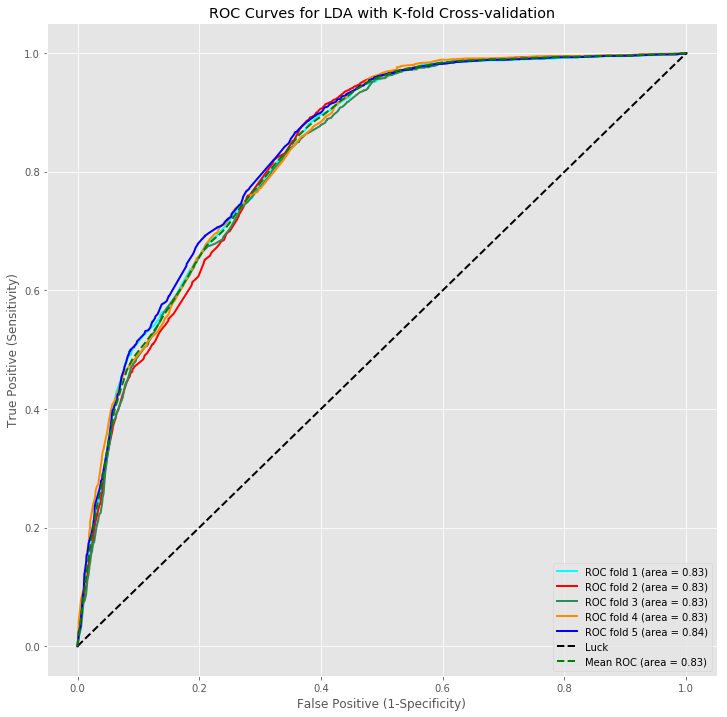

Excel file was saved to: output/lda-cms.csv
Confusion matrix image was saved to: output/lda-best-tp-cm.png


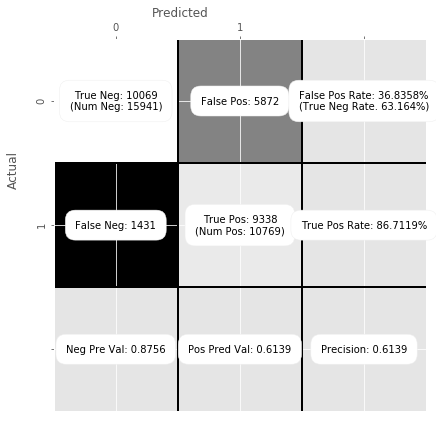

,Cat,AgeRange_0,AgeRange_1_4,AgeRange_10_14,AgeRange_15_20,MixBreed,SexuponOutcome_Intact_Male,SexuponOutcome_Neutered_Male,SexuponOutcome_Spayed_Female,SexuponOutcome_Unknown,...,ColorCat_Sable,ColorCat_Sable_White,ColorCat_Tortie,ColorCat_Tricolor,ColorCat_White,ColorCat_Yellow,Adopted,Prob_0,Prob_1,Predicted
26705,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.485571,0.514429,1
26706,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,0,1,0.328707,0.671293,1
26707,1,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0.487954,0.512046,1
26708,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0.232283,0.767717,1
26709,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0.232283,0.767717,1


In [17]:
# Run LDA with cross-validation and plot ROC curves
def fit_lda():
    """
    Fit a model with Linear Discriminant Analysis (LDA).
    """
    # Estimate priors.
    gnb = GaussianNB()
    gnb.fit(X, y)
    priors = gnb.class_prior_

    #rand = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=NUM_CV) # /shuffle=True, random_state=rand
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
    roc_kfolds = []
    cm_folds = []
    lda_actual = []
    lda_prob = []
    best_mean_cutoff = 0.0
    predicted_data = []
    tn=[]; fp=[]; fn=[]; tp=[];

    # For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
    # train, test are of type <type 'numpy.ndarray'>
    i = 0
    for (train, test) in cv.split(X, y):

        test_actual = y[test]
        test_X = X[test]
        train_X = X[train]
        train_y = y[train]

        # train LDA on training dataset
        lda = LinearDiscriminantAnalysis(solver=LDA_SOLVER, priors=priors, 
                                         shrinkage=LDA_SHRINKAGE, store_covariance=True).fit(train_X, train_y)
        # test LDA on test dataset
        # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
        prob = lda.predict_proba(test_X)

        # get predicted values: 1/0; default threshold/cutoff is 0.5
        predicted = lda.predict(test_X)
        train_predicted = lda.predict(train_X)

        # Compute ROC curve
        # fpr = false positive rate (1-specificity)
        # tpr = true positive rate (sensitivity)
        fpr, tpr, thresholds = roc_curve(test_actual, prob[:, 1]) # returns <type 'numpy.ndarray'> x 3

        # add mean Sensitivity
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        lda_actual.extend(test_actual)
        lda_prob.extend(prob)
        roc_kfolds.append([tpr, fpr])
        best_tpr, best_fpr, best_cutoff, _tn, _fp, _fn, _tp = u.get_best_cutoff(actual=test_actual, prob=prob)
        best_mean_cutoff += best_cutoff
        tn.append(_tn)
        fp.append(_fp)
        fn.append(_fn)
        tp.append(_tp)
        
        print('Fold %d, TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f' % (i+1, best_tpr, 1-best_fpr, best_cutoff))
        
        predicted_data.extend(u.combine(prob, test_X, test_actual, predicted))

        i += 1
        #/for (train, test)...

    best_mean_cutoff /= float(NUM_CV)
    
    tneg = sum(tn)
    fpos = sum(fp)
    fneg = sum(fn)
    tpos = sum(tp)
    best_mean_tpr = tpos / (tpos+fneg)
    best_mean_tnr = tneg / (tneg+fpos)
    print('Means:  TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f'%(best_mean_tpr, best_mean_tnr, best_mean_cutoff))

    # Display ROC Curve, output to CSV
    u.show_roc(roc_kfolds, mean_tpr, mean_fpr, 'ROC Curves for LDA with K-fold Cross-validation', 2, OUTPUT_DIR+'lda-roc')

    if OUTPUT_TO_CSV:
        u.output_cms(OUTPUT_DIR+'lda-cms', cm_folds, OUTPUT_DIR+'LDA_Test_Folds') # output to CSV

    # Display Confustion Matrix, output to PNG
    cm = np.asarray( [[tneg,fpos],[fneg,tpos]] )
    u.show_confusion_matrix(cm, ['0','1'], (6,6), 12, OUTPUT_DIR+'lda-best-tp-cm')
    
    # Output final dataset with predictions to CSV  
    col_names = np.append(np.asarray(significant_features), np.asarray([TARGET_NAME, 'Prob_0', 'Prob_1', 'Predicted']))
    df = pd.DataFrame(data=predicted_data, columns=col_names)
    if OUTPUT_TO_CSV:
        df.to_csv(OUTPUT_DIR + 'lda-validation.csv')
        
    display(df.tail())
    
if __name__ == '__main__':
    fit_lda()

### Figure 5.1

Fold 1, TPR: 0.87465, TNR: 0.62904, Cutoff: 0.38000
Fold 2, TPR: 0.89786, TNR: 0.61230, Cutoff: 0.35000
Fold 3, TPR: 0.86908, TNR: 0.62014, Cutoff: 0.37000
Fold 4, TPR: 0.85283, TNR: 0.64335, Cutoff: 0.42000
Fold 5, TPR: 0.87320, TNR: 0.63676, Cutoff: 0.41000
Means:  TPR: 0.87353, TNR: 0.62832, Cutoff: 0.38600
ROC image was saved to: output/logit-roc.png


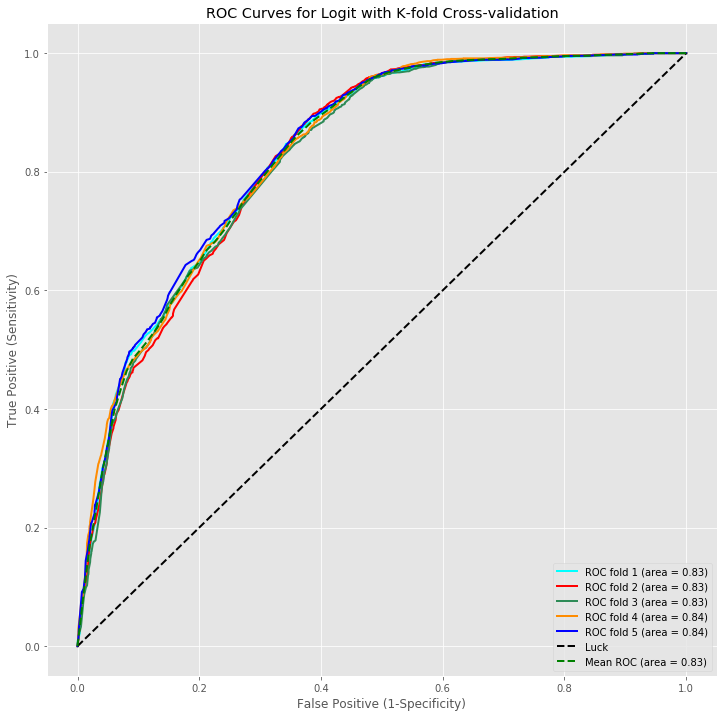

Excel file was saved to: output/logit-cms.csv
Confusion matrix image was saved to: output/logit-best-tp-cm.png


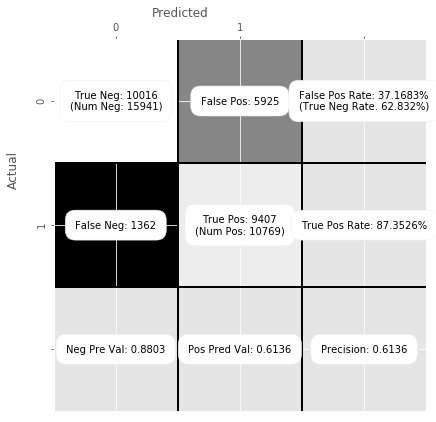

,Cat,AgeRange_0,AgeRange_1_4,AgeRange_10_14,AgeRange_15_20,MixBreed,SexuponOutcome_Intact_Male,SexuponOutcome_Neutered_Male,SexuponOutcome_Spayed_Female,SexuponOutcome_Unknown,...,ColorCat_Sable,ColorCat_Sable_White,ColorCat_Tortie,ColorCat_Tricolor,ColorCat_White,ColorCat_Yellow,Adopted,Prob_0,Prob_1,Predicted
26705,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.482361,0.517639,1
26706,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,0,1,0.342183,0.657817,1
26707,1,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0.472601,0.527399,1
26708,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0.244152,0.755848,1
26709,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0.244152,0.755848,1


In [18]:
# Run logistic Regression with cross-validation and plot ROC curves
# Logit can use categorical variaables. Append to cols and get new data set
def fit_logit():
    """
    Fit a model with Logistic Regression.
    """
    #rand = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=NUM_CV) # split into N folds /shuffle=True, random_state=rand
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
    roc_kfolds = [] # store TPR and FPR for each iteration and plot to ROC curve
    cm_folds = []
    logit_actual = []
    logit_prob = []
    best_mean_cutoff = 0.0
    best_mean_tpr = 0.0
    best_mean_fpr = 0.0
    predicted_data = []
    tn=[]; fp=[]; fn=[]; tp=[];
    
    # For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
    # train, test are of type <type 'numpy.ndarray'>
    i = 0
    for (train, test) in cv.split(X, y):

        test_actual = y[test]
        test_X = X[test]
        train_X = X[train]
        train_y = y[train]

        # train Logit on training dataset
        logit = LogisticRegression()
        logit.fit(train_X, train_y)

        # test Logit on test dataset
        # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
        prob = logit.predict_proba(test_X)

        # get predicted values: 1/0; default threshold/cutoff is 0.5
        predicted = logit.predict(test_X)
        train_predicted = logit.predict(train_X)

        # Compute ROC curve
        # fpr = false positive rate (1-specificity)
        # tpr = true positive rate (sensitivity)
        fpr, tpr, thresholds = roc_curve(test_actual, prob[:, 1]) # returns <type 'numpy.ndarray'> x 3
        
        # add mean Sensitivity
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        logit_actual.extend(test_actual)
        logit_prob.extend(prob)
        best_tpr, best_fpr, best_cutoff, _tn, _fp, _fn, _tp = u.get_best_cutoff(actual=test_actual, prob=prob)
        roc_kfolds.append([tpr, fpr])
        best_mean_cutoff += best_cutoff
        tn.append(_tn)
        fp.append(_fp)
        fn.append(_fn)
        tp.append(_tp)
        
        print('Fold %d, TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f' % (i+1, best_tpr, 1-best_fpr, best_cutoff))
    
        # Collect test set into combined table
        predicted_data.extend(u.combine(prob, test_X, test_actual, predicted))
        
        i += 1
    #/for (train, test)...

    best_mean_cutoff /= float(NUM_CV)
    tneg = sum(tn)
    fpos = sum(fp)
    fneg = sum(fn)
    tpos = sum(tp)
    best_mean_tpr = tpos / (tpos+fneg)
    best_mean_tnr = tneg / (tneg+fpos)
    print('Means:  TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f'%(best_mean_tpr, best_mean_tnr, best_mean_cutoff))

    # Display ROC Curve, output to CSV
    u.show_roc(roc_kfolds, mean_tpr, mean_fpr, 'ROC Curves for Logit with K-fold Cross-validation', 2, OUTPUT_DIR+'logit-roc')

    if OUTPUT_TO_CSV:
        u.output_cms(OUTPUT_DIR+'logit-cms', cm_folds, OUTPUT_DIR+'Logit_Test_Folds') # output to excel

    # Display Confustion Matrix, output to PNG
    cm = np.asarray( [[tneg,fpos],[fneg,tpos]] )
    u.show_confusion_matrix(cm, ['0','1'], (6,6), 12, OUTPUT_DIR+'logit-best-tp-cm')
    
    # Output final dataset with predictions to CSV  
    col_names = np.append(np.asarray(significant_features), np.asarray([TARGET_NAME, 'Prob_0', 'Prob_1', 'Predicted']))
    df = pd.DataFrame(data=predicted_data, columns=col_names)
    if OUTPUT_TO_CSV:
        df.to_csv(OUTPUT_DIR + 'logit-validation.csv')
        
    display(df.tail())
    
if __name__ == '__main__':
    fit_logit()

### Figure 6.0 - JMP Model

<img src="https://raw.githubusercontent.com/jbonfardeci/austin-animal-shelter-model/master/jmp_roc.png" alt="JMP ROC" />
<div>
<table style="font-size:24px;">
    <thead>
        <tr>
            <th>Adopted</th>
            <th>1</th>
            <th>0</th>
        </tr>
    </thead>
    <tbody>
        <tr><td>1</td><td>7228</td><td>3541</td></tr>
        <tr><td>0</td><td>2992</td><td>12968</td></tr>
    </tbody
</table>
</div>
<br /><br />
<p>AUC = <strong>0.83431</strong></p>
<p>Sensitivity = TP / (TP + FN) = 7228 / (7228 + 2992) = <strong>70.72%</strong></p>
<p>Specificity = TN / (TN + FP) = 12968 / (12968 + 3541) = <strong>78.55%</strong></p>
<p>Precision = TP / (TP + FP) = 7228 / (7228 + 3541) = <strong>67.12%</strong></p>